In [21]:
from Training.generator_prevbit import make_train_test
import numpy as np
from SSM.hippo import hippo_legs, discretize_bilinear
from SSM.helpers import sigmoid, binary_cross_entropy
from SSM.model_2 import SimpleSSM
import matplotlib.pyplot as plt

Repeat of the prev-bit experiment for reference

In [22]:
# Generate data

# Size of data matters alot, especially for how simple the task is. If the training data is very large, then the model will learn it within one epoch and the average loss will be small even on the first pass
x_train, y_train, x_test, y_test = make_train_test(
    n_train=100,
    n_test=10,
    T=10,
    seed=0,
)

In [23]:
model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
num_epochs = 100
learning_rate = 1e-2


In [24]:


u = x_train[0]            
t = y_train[0]            
logits, _ = model.forward(u)
print(logits)
probs = sigmoid(logits)

eps = 1e-8
loss_manual = -np.mean(
    t * np.log(probs + eps) +
    (1 - t) * np.log(1 - probs + eps)
)
print("manual BCE on first sequence:", loss_manual)

loss, _ = model.loss_and_grads(u, t)
print("loss_and_grads loss:", loss)


[[-0.01467987]
 [ 0.00279839]
 [-0.02117673]
 [ 0.0101019 ]
 [-0.01802538]
 [ 0.012675  ]
 [-0.00912645]
 [ 0.00612219]
 [-0.00484163]
 [-0.01053199]]
manual BCE on first sequence: 0.693127495054777
loss_and_grads loss: 0.693127495054777


Have a look how the hippo matrix looks like, its discretized version and and the discretized version of the A matrix evolves with epochs of training

In [25]:
print(model.A_ct)
print(model.A)
los = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(x_train.shape[0]):
        u = x_train[i]      
        tgt = y_train[i]    

        loss, grads = model.loss_and_grads(u, tgt)
        

        
        model.step(grads, lr=learning_rate)
        epoch_loss += loss
    los.append(epoch_loss / x_train.shape[0])
    print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

print(model.A)

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
[[ 3.33333333e-01 -3.37864825e-16 -2.06854932e-16  1.93156033e-16
   1.87791344e-16 -6.85528257e-17 -3.86372710e-16 -2.22044605e-16]
 [-5.77350269e-01  3.90787006e-16 

In [26]:

print(model.forward(x_train[0])[0])

[[ 5.96394643e-03]
 [ 1.99283384e+01]
 [ 1.54130363e+01]
 [ 1.12995515e+01]
 [-1.20004671e+01]
 [-9.83601201e+00]
 [-7.02206467e+00]
 [-3.81679442e+00]
 [-2.29498941e+00]
 [-1.67799684e+00]]


In [27]:
# Testing ERror
print("mean of y_train:", y_train.mean())
print("min target:", y_train.min(), "max target:", y_train.max())
print("mean target over all train data:", y_train.mean())

u = x_train[0].reshape(-1)
t = y_train[0].reshape(-1)
print("input:  ", u.astype(int).tolist())
print("target: ", t.astype(int).tolist())

import numpy as np
eps = 1e-8
p = 0.01
y = y_train.reshape(-1)   # flatten all targets

baseline_loss = -np.mean(
    y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
)

print("baseline constant-p loss:", baseline_loss)

mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887


How the loss function decreases when the Hippo-LegS matrix is first initiliazed as the continuous A matrix, before it gets discretized

Text(0.5, 1.0, 'hippo')

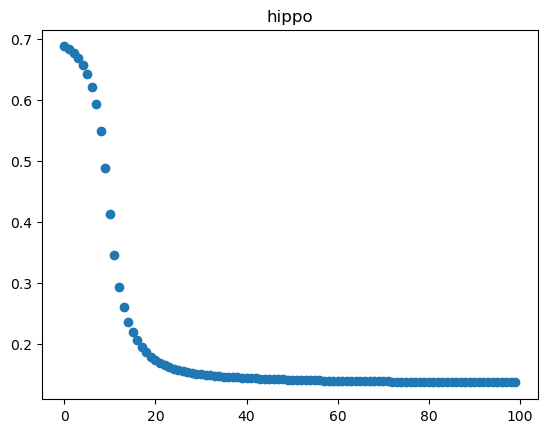

In [28]:
import matplotlib.pyplot as plt

plt.scatter([i for i in range(num_epochs)], los)
plt.title('hippo')

A few examples of the predicted prev-bit sequence and the actual test prev-bit sequence. Most of them are identical

In [31]:
for i in range(7):
    u = x_test[i]
    tgt = y_test[i]
    logits, _ = model.forward(u)
    probs = sigmoid(logits)
    print('#############')
    print((probs > 0.5).astype(int))
    print(tgt)
    print('####################')

#############
[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]]
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]
####################
#############
[[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]
####################
#############
[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]
####################
#############
[[0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]]
[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
####################
#############
[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]]
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
####################
#############
[[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]]
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]
####################
#############
[[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]]
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]

In [29]:
N = x_test.shape[0]
total_loss = 0.0
total_correct = 0
total_bits = 0

for i in range(N):
    u = x_test[i]      
    tgt = y_test[i]   
    

    # forward pass only (no grads)
    logits, _ = model.forward(u)

    # loss for this sequence
    loss = binary_cross_entropy(logits, tgt)
    total_loss += loss

    # compute accuracy for this sequence
    probs = sigmoid(logits)
    preds = (probs > 0.5).astype(int)   # threshold at 0.5

    print('\n\n')

    total_correct += (preds == tgt).sum()
    total_bits += tgt.size

avg_loss = total_loss / N
accuracy = total_correct / total_bits

print(avg_loss)
print(accuracy)































0.13736903308766374
0.94


- to demonstrate that using the hippo-legS matrix when initializing the continuous hidden A matrix, let's look at the loss function descent when A is initialized to be random
- We can see the theoretical justification behind using hippo-legS in action. The loss function descent with each epoch is more efficient, and error approximation bounds are established (since hippo-legS achieves 0.94 accuracy while random achieves 0.96 accuracy)

[[0.46762924 0.83379187 0.44628224 0.53521161 0.52435991 0.8290086
  0.1862685  0.67949464]
 [0.75320085 0.48271543 0.24753083 0.05513703 0.66787404 0.65930207
  0.78462399 0.06536004]
 [0.44318742 0.38983115 0.68515108 0.02882439 0.72071611 0.19788835
  0.43317018 0.51914148]
 [0.7728236  0.41850766 0.27523728 0.91397791 0.4147162  0.25178773
  0.38287786 0.20032129]
 [0.35415716 0.20560713 0.34300953 0.76275283 0.10918257 0.39200739
  0.01877231 0.92877992]
 [0.37773473 0.30049526 0.5253342  0.94192644 0.77961915 0.30069384
  0.67443404 0.49834157]
 [0.20633886 0.77967973 0.11301741 0.56085552 0.3223366  0.38889393
  0.1713495  0.5703714 ]
 [0.17158404 0.96170409 0.98614563 0.31077575 0.28784305 0.11395901
  0.42834665 0.56744627]]
manual BCE on first sequence: 4.625290501238763
loss_and_grads loss: 4.625290501238763
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0

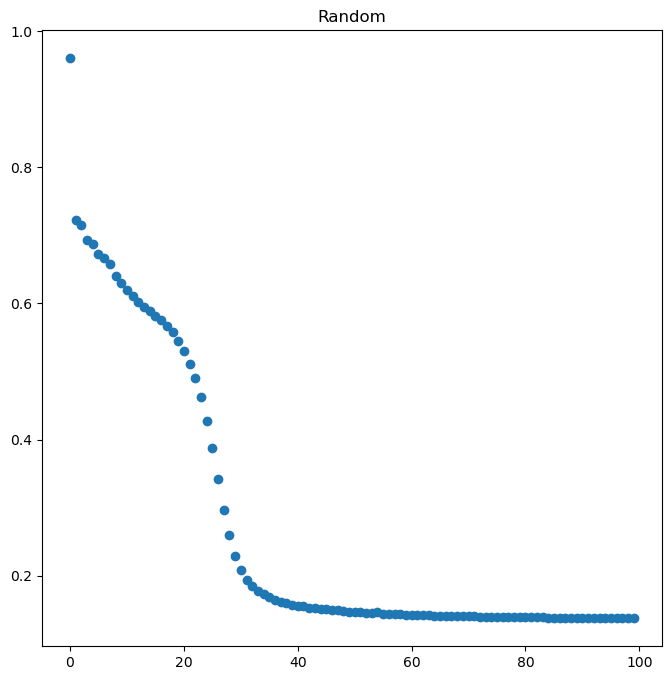

[[0.70714528 0.72055463 0.97612191 0.89838983 0.4269174  0.30528995
  0.84234456 0.60778559]
 [0.43199564 0.43124327 0.06868455 0.05823205 0.90069797 0.37507705
  0.24021128 0.51567491]
 [0.44460142 0.36641069 0.66745234 0.20013429 0.93838982 0.66858165
  0.18028868 0.29842059]
 [0.96109637 0.46721022 0.85864621 0.64504207 0.35321739 0.32488679
  0.97975649 0.15807944]
 [0.58061853 0.21353726 0.57852931 0.51149127 0.44855058 0.88967213
  0.54181411 0.91385519]
 [0.89592695 0.84770842 0.36766303 0.25707932 0.47435863 0.95329052
  0.12877058 0.79614345]
 [0.91885125 0.78956398 0.29780717 0.98398162 0.85431268 0.93548875
  0.02737266 0.34034535]
 [0.26574844 0.41327401 0.24363799 0.69341497 0.5784541  0.48781274
  0.41588951 0.51541073]]
manual BCE on first sequence: 3.893729716232908
loss_and_grads loss: 3.893729716232908
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 

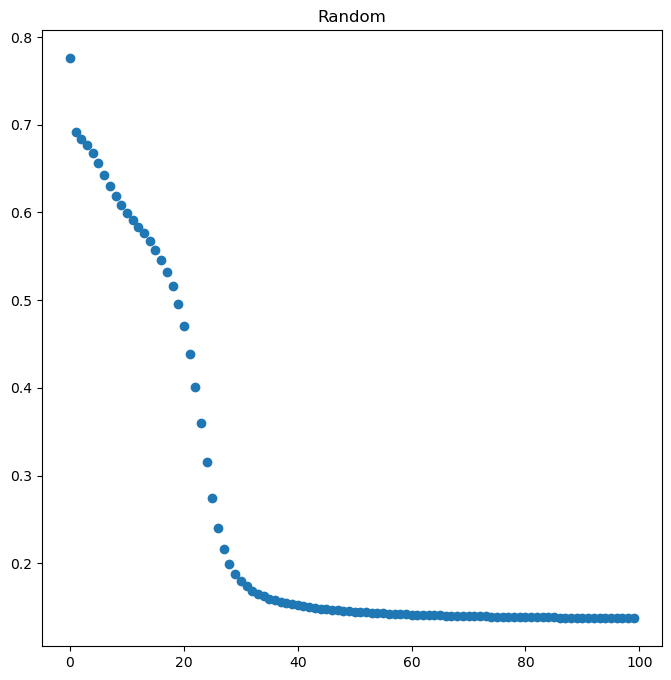

[[0.57211927 0.4765882  0.82020891 0.41752479 0.88901429 0.56163308
  0.08066358 0.61216006]
 [0.53132784 0.95296206 0.69489545 0.69528703 0.7980552  0.73722018
  0.79423292 0.20823195]
 [0.20965237 0.88189166 0.16327661 0.85308895 0.22106908 0.97601673
  0.58943209 0.39641591]
 [0.26190785 0.83745317 0.40489379 0.51114759 0.41318134 0.43023827
  0.30612404 0.3372061 ]
 [0.89195089 0.32177427 0.33653233 0.94063124 0.89509581 0.10759768
  0.4599638  0.51635423]
 [0.4540763  0.94007731 0.35603583 0.54341151 0.58769051 0.06601962
  0.91659937 0.72090892]
 [0.72127041 0.9663533  0.77829901 0.69063044 0.44976999 0.30618454
  0.95612651 0.53902208]
 [0.02972809 0.662645   0.91876922 0.13354404 0.60879142 0.77608381
  0.67004364 0.45762992]]
manual BCE on first sequence: 3.6852895345439407
loss_and_grads loss: 3.6852895345439407
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0

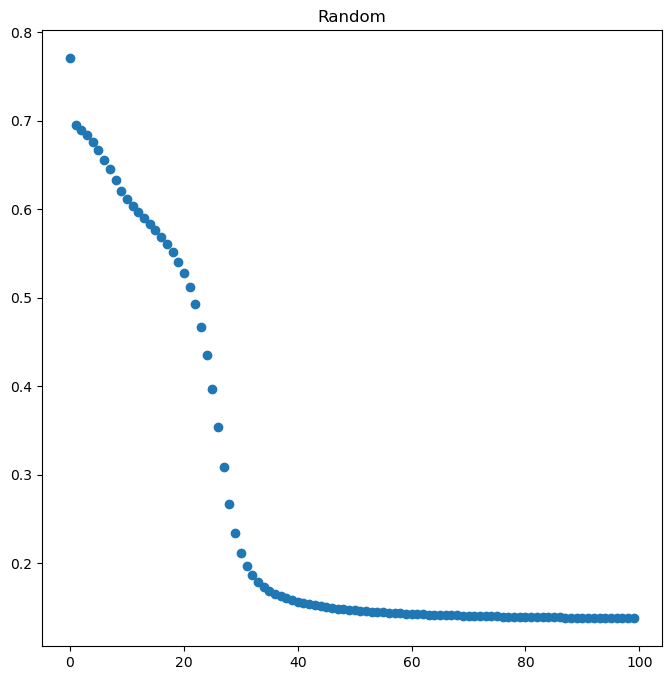

[[0.96459543 0.20361356 0.11454231 0.70578127 0.3311125  0.93324856
  0.97435308 0.98891267]
 [0.93038535 0.84263628 0.14986688 0.03035117 0.56910628 0.54396328
  0.16854622 0.98478347]
 [0.71769663 0.26085328 0.24412829 0.92277413 0.76122836 0.8965018
  0.62541294 0.94323744]
 [0.29336836 0.50860501 0.82919877 0.73238352 0.32038604 0.04437885
  0.90673317 0.95907702]
 [0.38129507 0.29296067 0.39624878 0.01800211 0.49288716 0.4865474
  0.64136262 0.38415224]
 [0.99596553 0.2006063  0.24585637 0.77831149 0.02104707 0.53414814
  0.79181669 0.14924751]
 [0.26432939 0.38728941 0.26637973 0.73971224 0.50438559 0.26038394
  0.56340701 0.09682169]
 [0.34178785 0.50873782 0.14382928 0.96705168 0.34573154 0.42253937
  0.26416575 0.54541852]]
manual BCE on first sequence: 4.364071679491706
loss_and_grads loss: 4.364071679491706
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0,

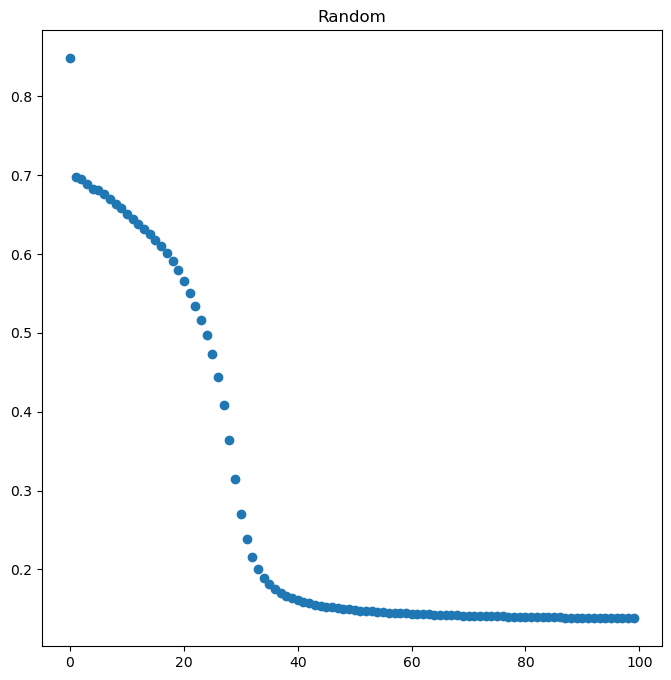

[[0.28367692 0.49971457 0.44365209 0.6291464  0.76021229 0.35896982
  0.38784761 0.92401722]
 [0.90410834 0.88847396 0.71866979 0.08650992 0.43574452 0.35548264
  0.46688434 0.00100881]
 [0.23280502 0.68612498 0.82311833 0.01072124 0.92002461 0.16459318
  0.01515258 0.99963876]
 [0.57541977 0.16328323 0.19452588 0.77932305 0.54791391 0.39589671
  0.97488013 0.09802634]
 [0.88651366 0.69165399 0.38023465 0.65875998 0.17814852 0.05639226
  0.77652065 0.60372275]
 [0.90036644 0.24210825 0.94252297 0.88685238 0.74591623 0.1840878
  0.51396106 0.79951964]
 [0.30479181 0.77877069 0.5003711  0.28111835 0.8854523  0.3504387
  0.34707483 0.55385422]
 [0.61617094 0.01483617 0.08770142 0.93398725 0.91032442 0.28944059
  0.8329372  0.64882553]]
manual BCE on first sequence: 4.359740042563416
loss_and_grads loss: 4.359740042563416
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0,

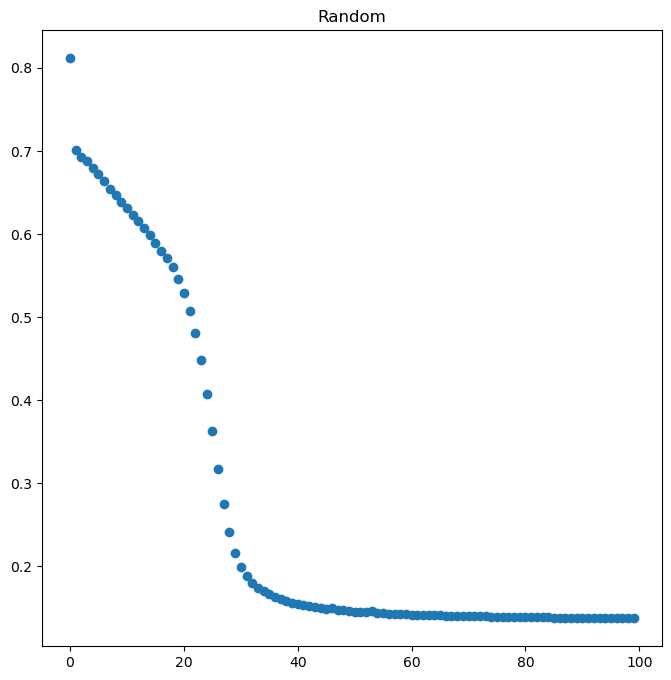

In [38]:



for j in range(5):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    model.A_ct = np.random.rand(model.A_ct.shape[0], model.A_ct.shape[1])
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]      
    t = y_train[0]         
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]   
            tgt = y_train[i]   

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
  

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]     
        tgt = y_test[i]    

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'Random')


   
    plt.show()

- We start the hippo experimentation by padding nth row of the hippo matrix
- the initial continuous A to be used and padded with is outputed and the diagram of the loss function decrease
  - the test accuracy is still good in all instances of row paddings

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6929511059046828
loss_and_grads loss: 0.6929511059046828
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

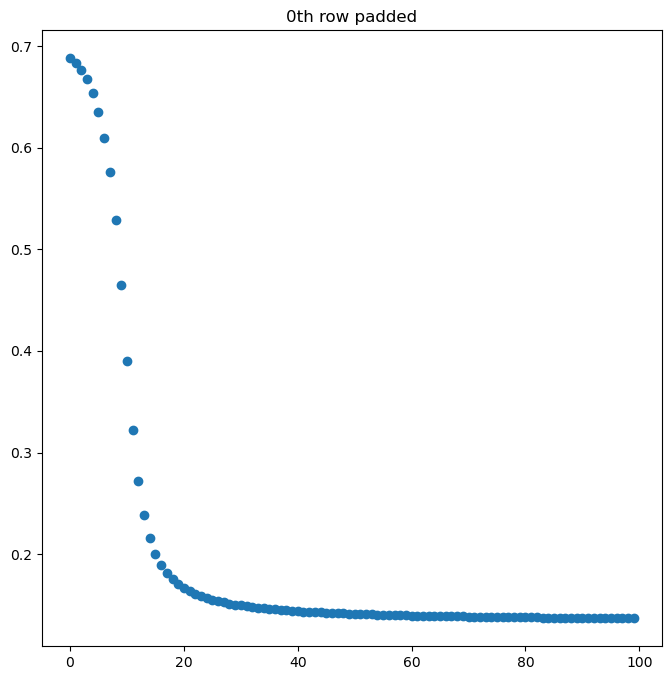

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6921658643950995
loss_and_grads loss: 0.6921658643950995
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

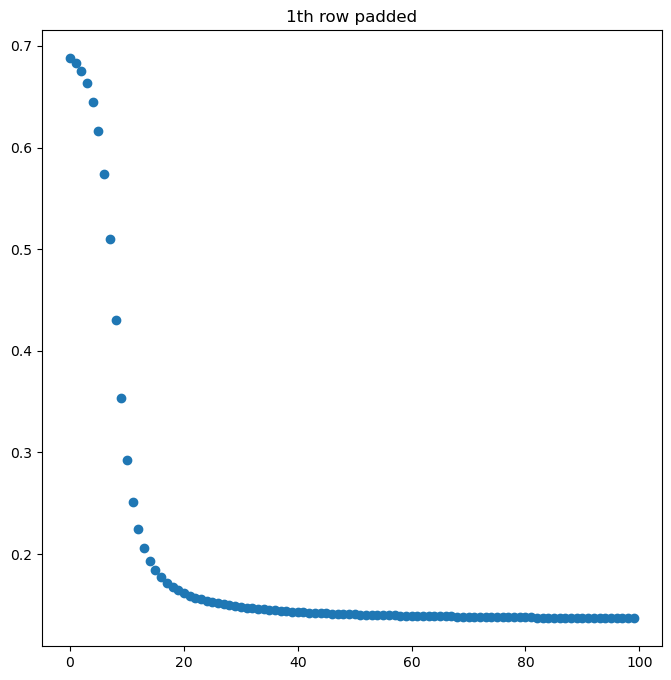

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6790929138659586
loss_and_grads loss: 0.6790929138659586
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

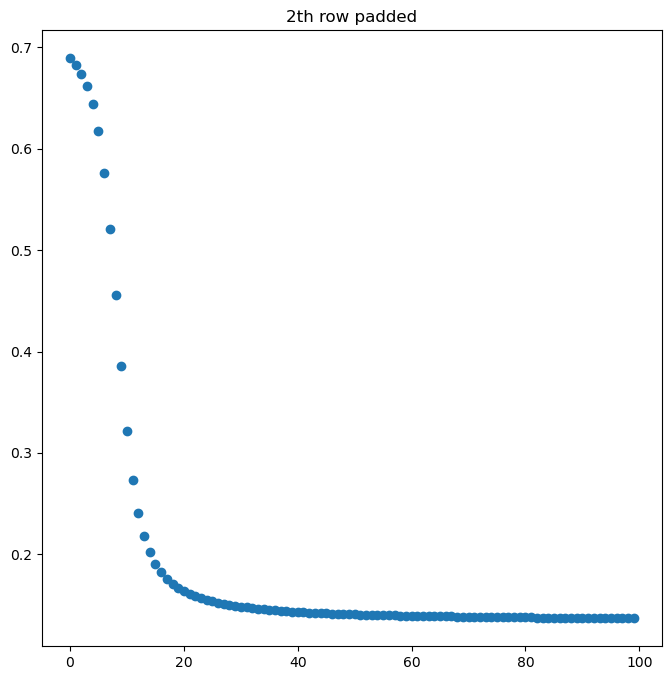

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6935810756197011
loss_and_grads loss: 0.6935810756197011
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

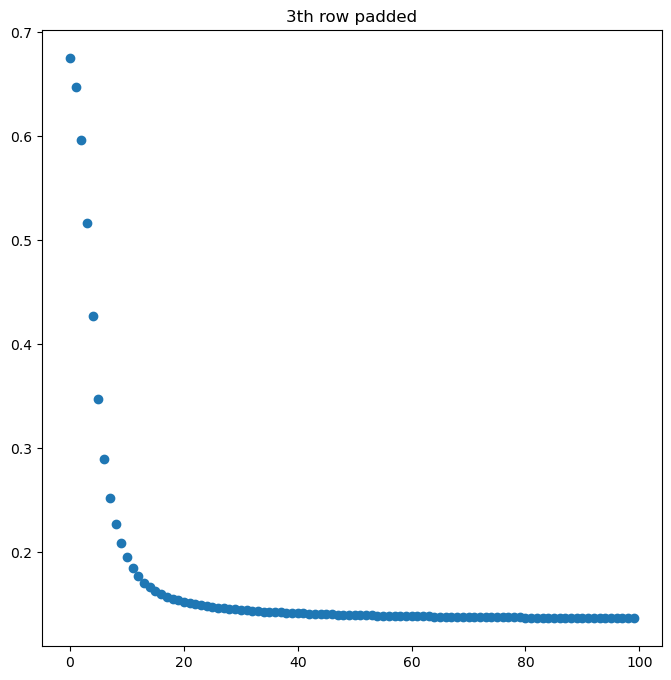

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.701235311819963
loss_and_grads loss: 0.701235311819963
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all trai

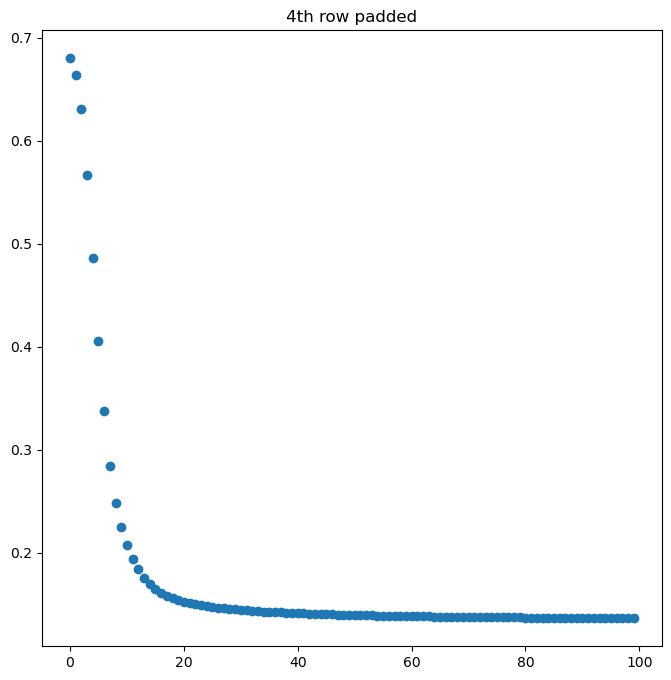

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6949883287574042
loss_and_grads loss: 0.6949883287574042
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data

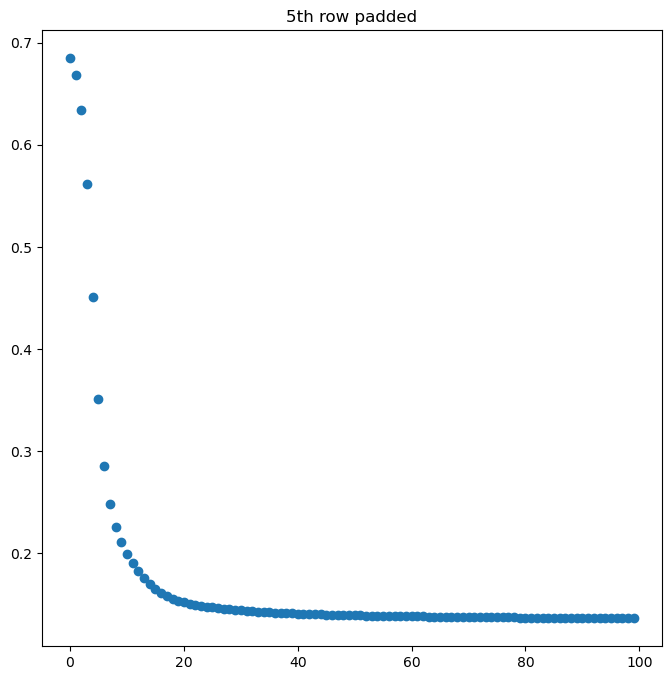

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6938499452521033
loss_and_grads loss: 0.6938499452521033
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data

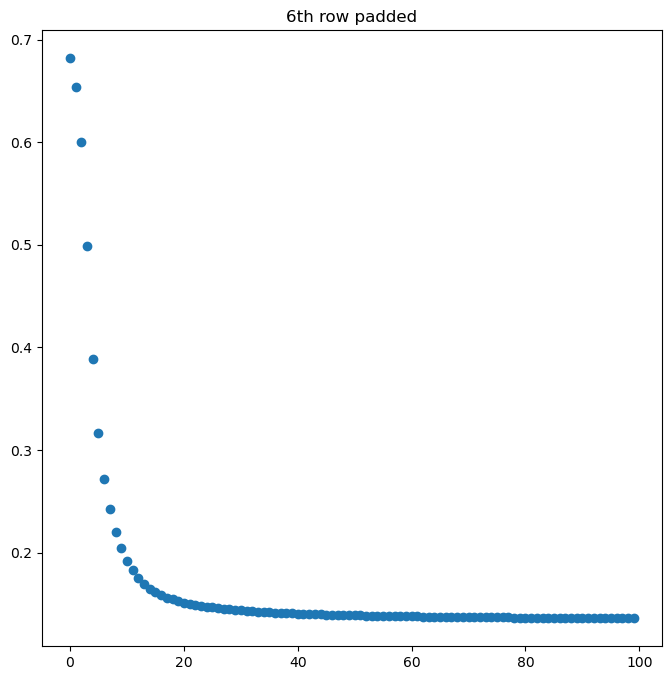

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]]
manual BCE on first sequence: 0.6899047953125348
loss_and_grads loss: 0.6899047953125348
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data

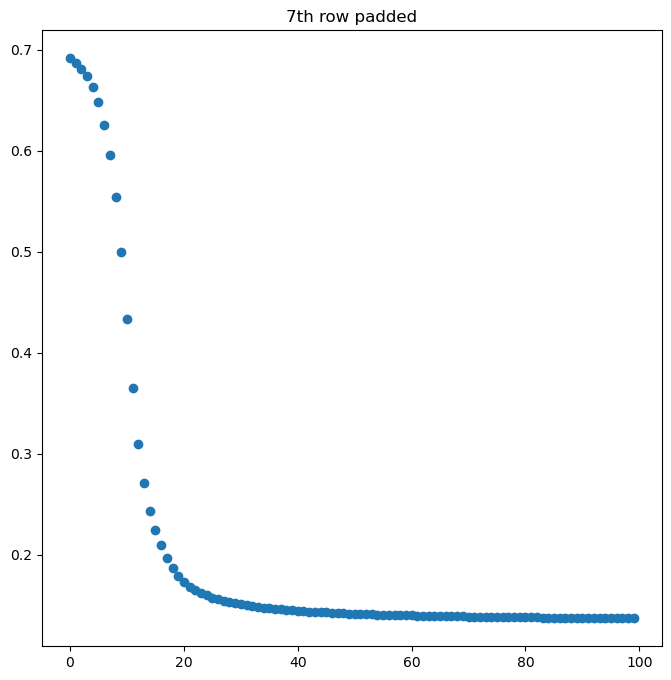

In [34]:



for j in range(8):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    model.A_ct[j] = [0]*model.A_ct.shape[1]
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]          
    t = y_train[0]            
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      
            tgt = y_train[i]    

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{j}th row padded')


   
    plt.show()

Now we pad elements below the diagonal with a block of zeroes, the test accuracy is still good

[[-1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-1.73205081 -2.          0.          0.          0.          0.
   0.          0.        ]
 [-2.23606798 -3.87298335 -3.          0.          0.          0.
   0.          0.        ]
 [-2.64575131 -4.58257569 -5.91607978 -4.          0.          0.
   0.          0.        ]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -6.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -7.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -8.        ]]
manual BCE on first sequence: 0.6938911097945207
loss_and_grads loss: 0.6938911097945207
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0

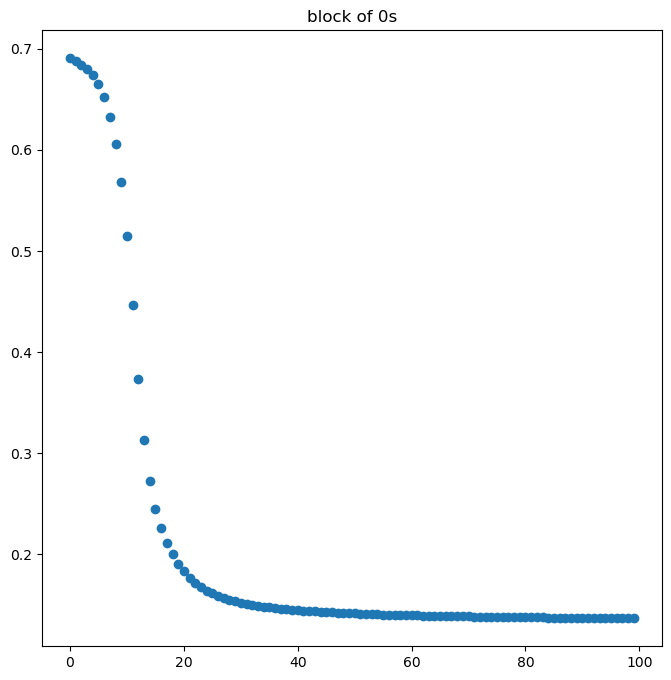

In [33]:



for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    for z in range(5,8):
        for zz in range(5):
            model.A_ct[z][zz] = 0
    model.A_ct[6][5] = 0
    model.A_ct[7][5] = 0
    model.A_ct[7][6] = 0
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]          
    t = y_train[0]            
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]     
            tgt = y_train[i]    

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
      

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'block of 0s')


   
    plt.show()

What if we pad everything but the diagonal elements? The test accuracy is still good (even slight improvement is shown)

In [ ]:



for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    for z in range(8):
        for zz in range(8):
            if z != zz:
                model.A_ct[z][zz] = 0
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)
    print(model.A)
    u = x_train[0]     
    t = y_train[0]        
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      
            tgt = y_train[i]   

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'diagonal only')


   
    plt.show()

Now we pad the diagonal elements starting with first and last diagonal element and then progressing towards the diagonal elements at the center of the matrix. We observe that even though the test accuracy is still good for all cases, weird training process is seen when the third and fourth element (diagonal elements at the center) are padded, which could be a precursor to unstable training process as we pad more diaongal elements

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 0.6978459060578873
loss_and_grads loss: 0.6978459060578873
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

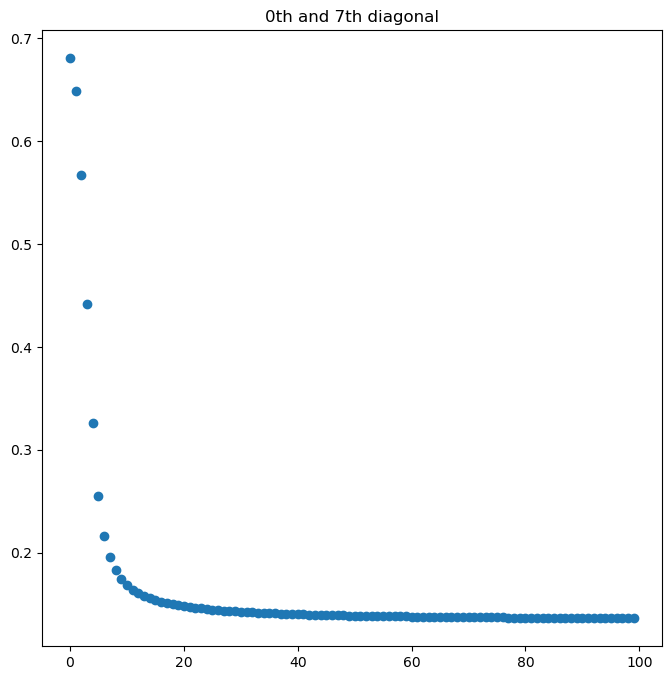

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6903436214578349
loss_and_grads loss: 0.6903436214578349
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

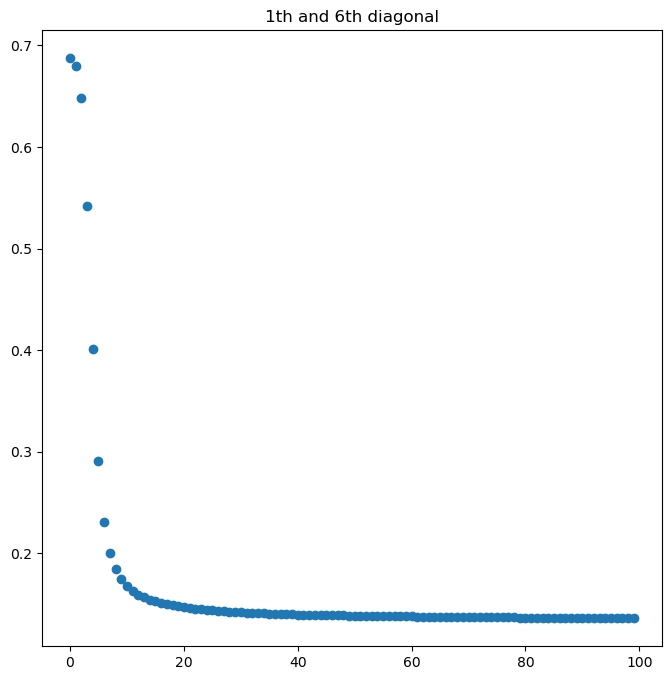

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.5613361687666181
loss_and_grads loss: 0.5613361687666181
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

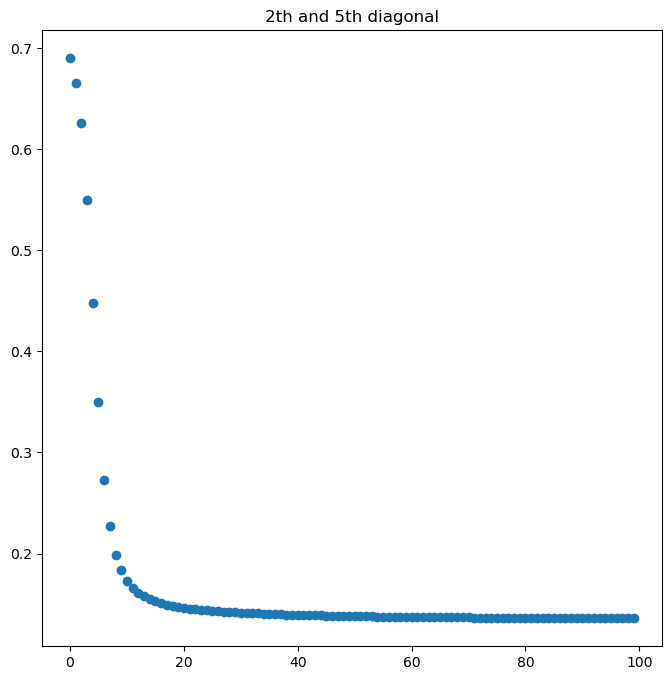

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.39356224813037777
loss_and_grads loss: 0.39356224813037777
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all 

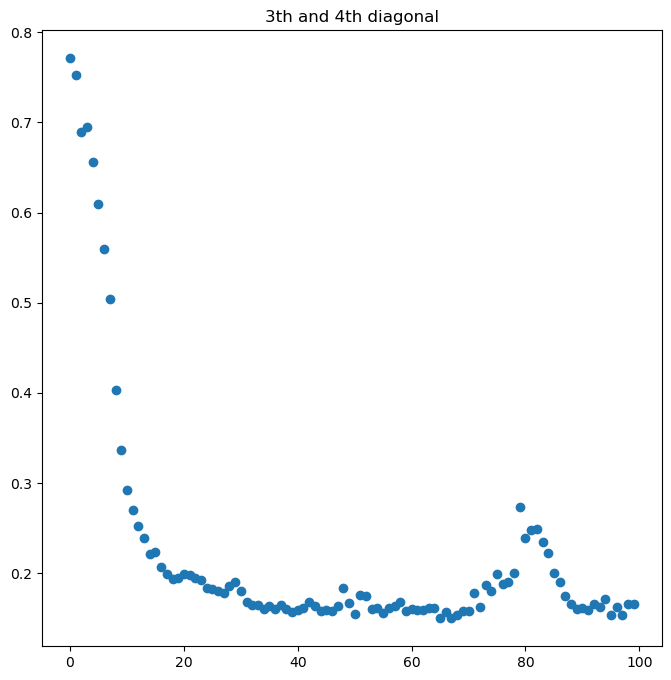

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.39356224813037777
loss_and_grads loss: 0.39356224813037777
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all 

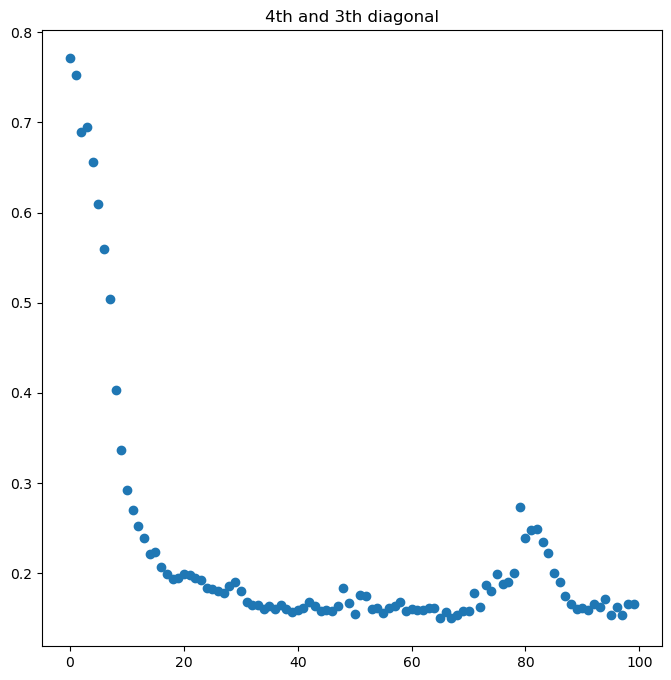

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.5613361687666181
loss_and_grads loss: 0.5613361687666181
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

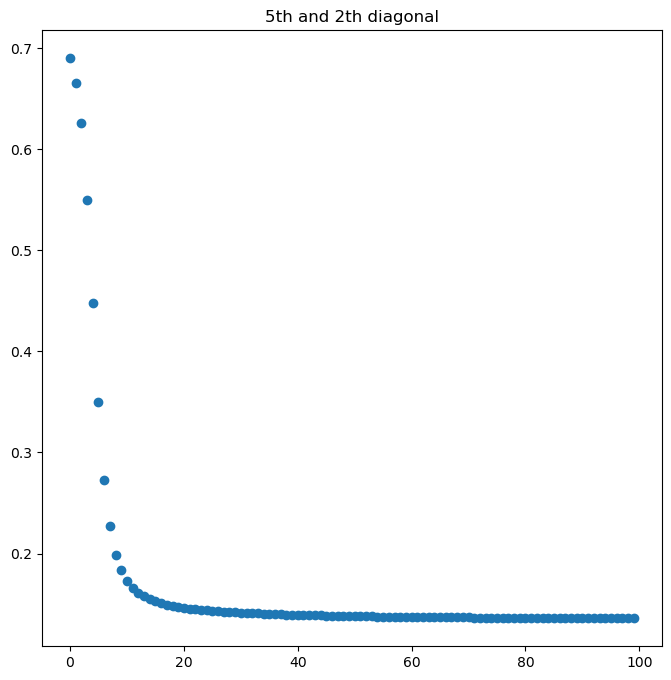

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6903436214578349
loss_and_grads loss: 0.6903436214578349
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

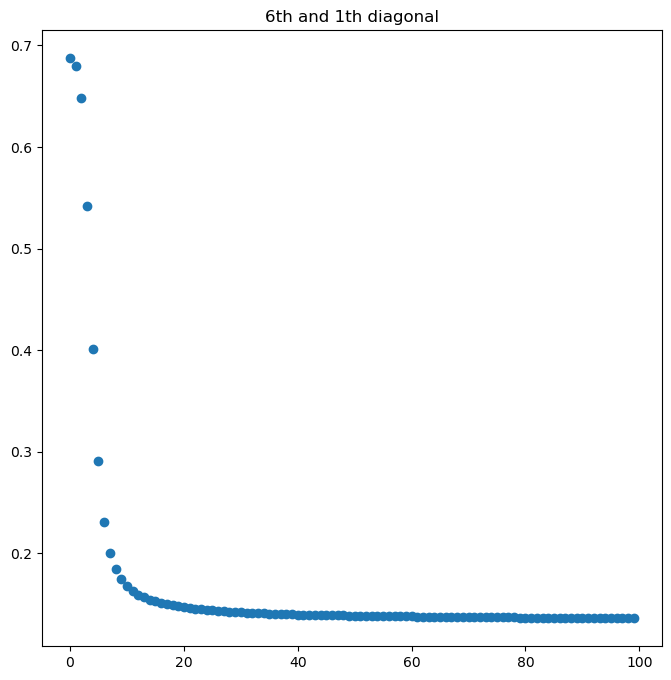

In [35]:



for j in range(7):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    model.A_ct[0+j][0+j] = 0
    model.A_ct[model.A_ct.shape[0]-1-j][model.A_ct.shape[0]-1-j] = 0
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]         
    t = y_train[0]          
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      
            tgt = y_train[i]    

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{j}th and {7-j}th diagonal')


   
    plt.show()

What if we pad the entire diagonal with 0s. We see that this results in an unstable training process, in which the loss function doesn't have a stable descent and in fact starts to increase

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 3.110963724470633
loss_and_grads loss: 3.110963724470633


/Users/admin/Desktop/phy_329/ssm/helpers.py:4: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
4.7677926766159935
0.62


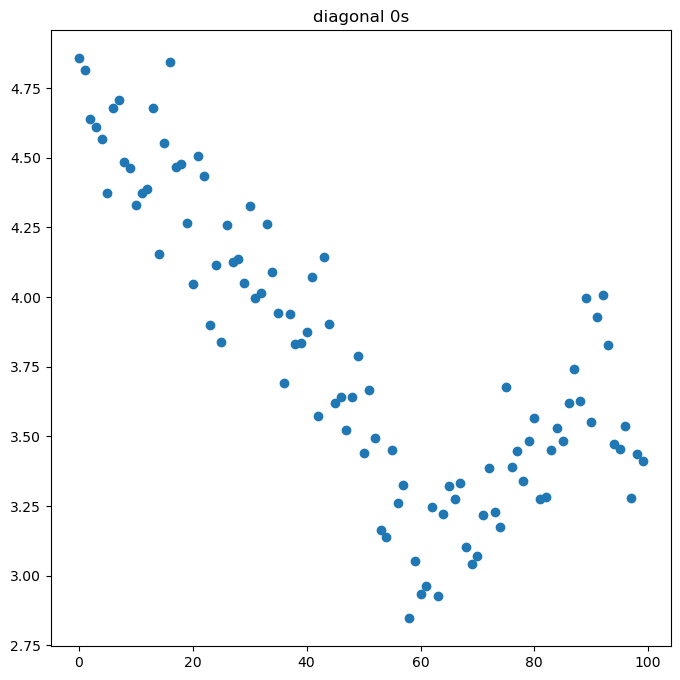

In [95]:



for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    for z in range(7):
        model.A_ct[0+z][0+z] = 0
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]            
    t = y_train[0]            
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i] 
            tgt = y_train[i]    

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'diagonal 0s')


   
    plt.show()

- we randomly pick 's' amount of diagonal elements from the diagonal of the hippo and pad them with 0s
- interesting observations can be seen at various values of 's'
- when s = 3, the only combination in which the padded diagonals will cause a worse test error is when 2nd, 3rd, and 4th diagonal element is removed (from 0.94 to 0.83 test accuracy)
- with larger s, some combinations lead to worse test accuracy, and some don't

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 7.0505070135132515
loss_and_grads loss: 7.0505070135132515
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

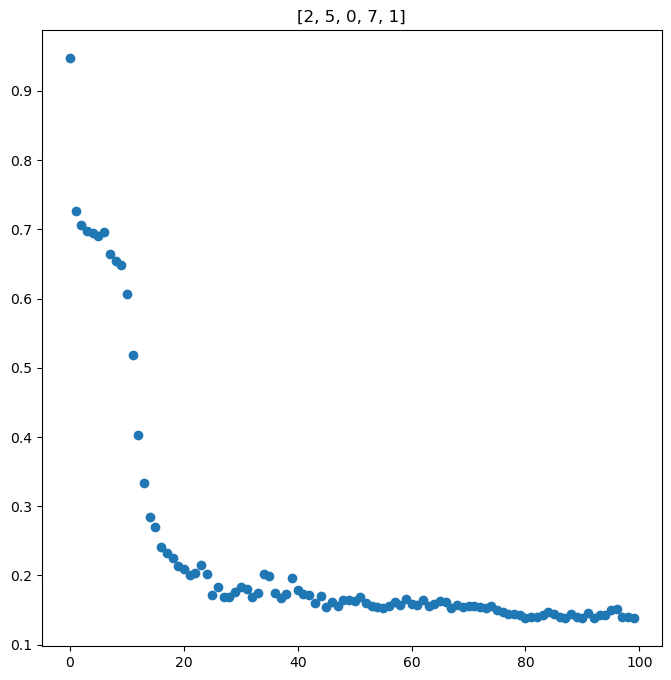

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.575407325955372
loss_and_grads loss: 0.575407325955372


/Users/admin/Desktop/phy329/SSM/helpers.py:9: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.19991748933328873
0.95


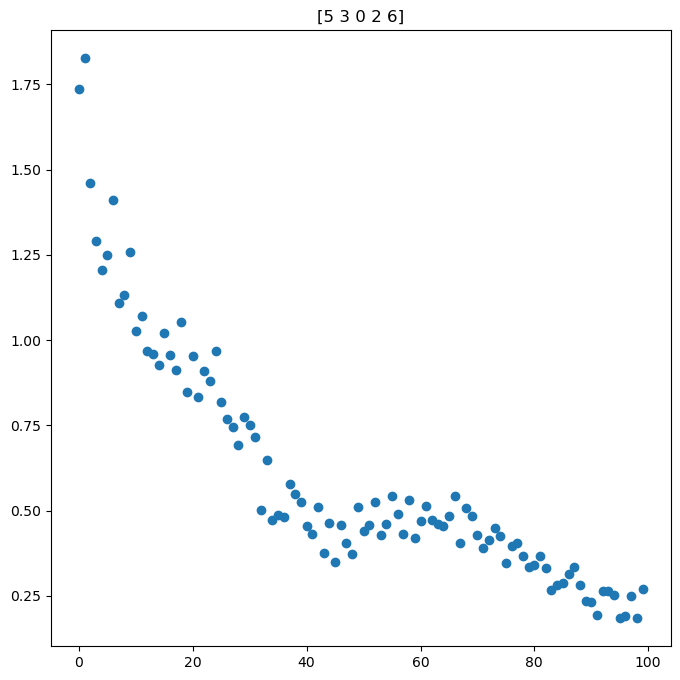

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 11.238848112998514
loss_and_grads loss: 11.238848112998514
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

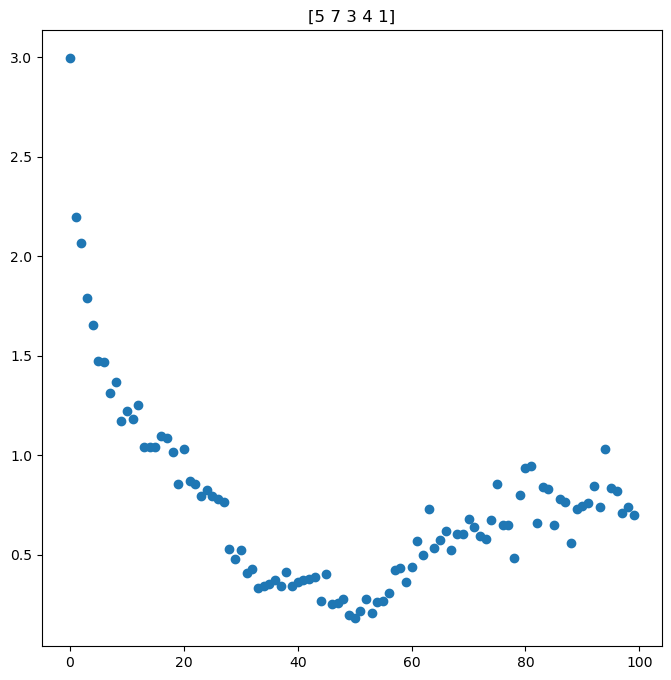

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.33823553058080125
loss_and_grads loss: 0.33823553058080125
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all 

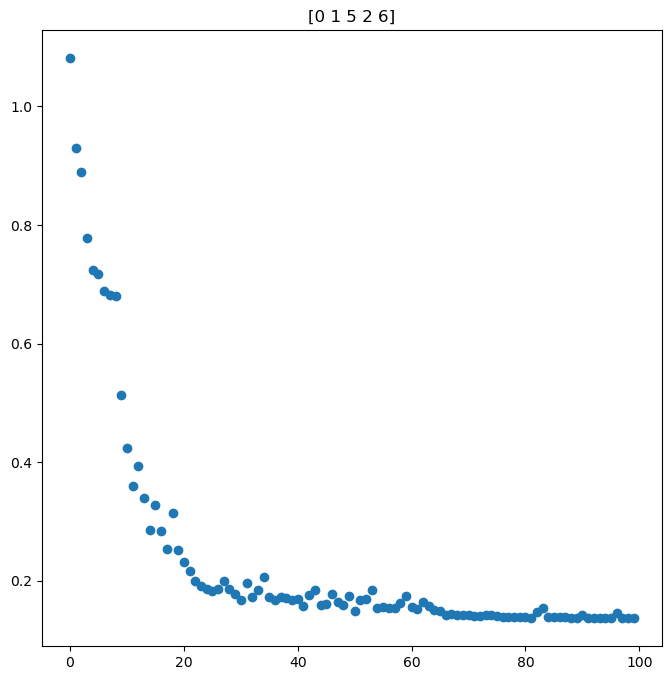

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 11.184068497338611
loss_and_grads loss: 11.184068497338611
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

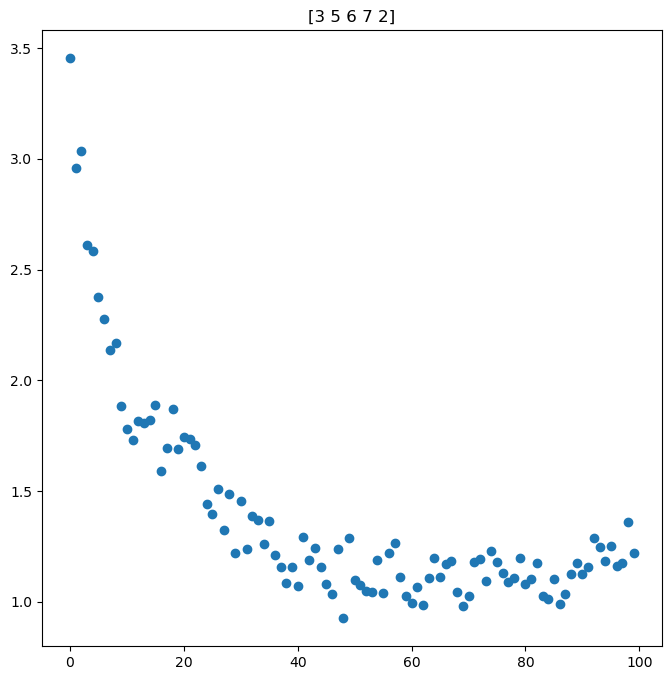

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 2.6134385136905154
loss_and_grads loss: 2.6134385136905154
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

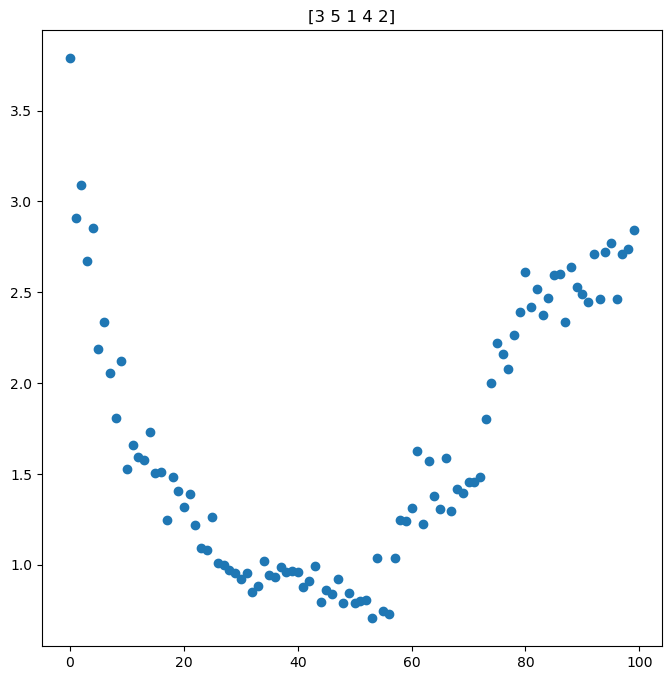

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.33823553058080125
loss_and_grads loss: 0.33823553058080125
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all 

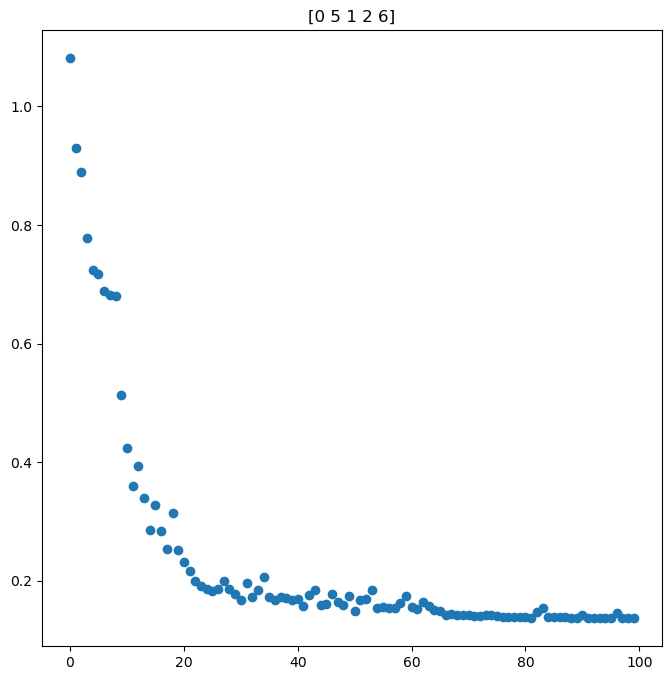

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.5810601057235916
loss_and_grads loss: 0.5810601057235916
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

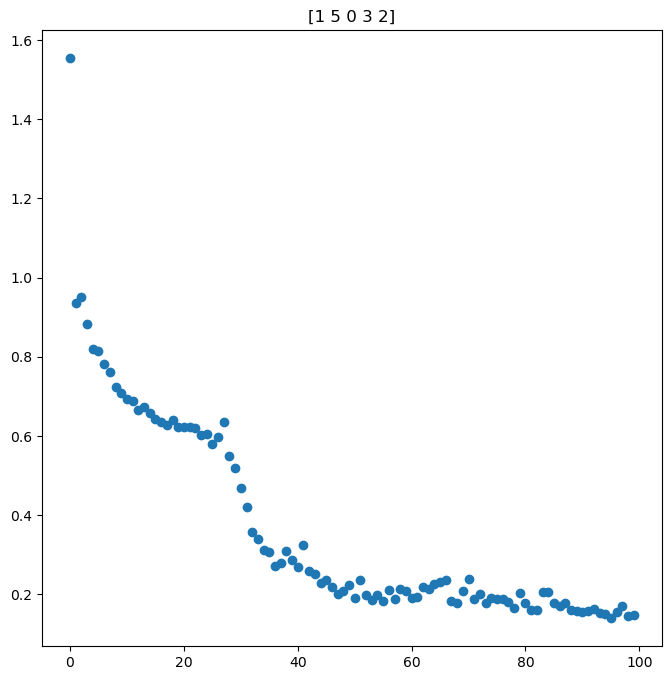

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 2.6952585959463295
loss_and_grads loss: 2.6952585959463295
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

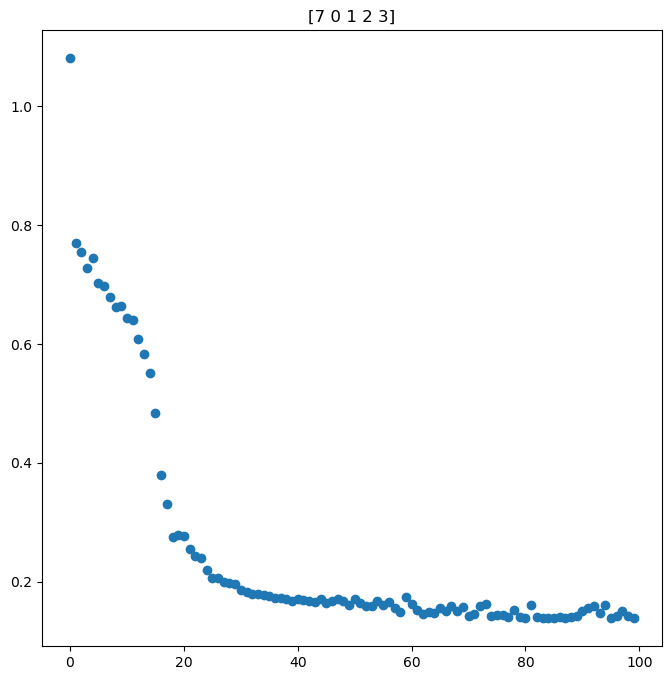

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.7507354727508714
loss_and_grads loss: 0.7507354727508714
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

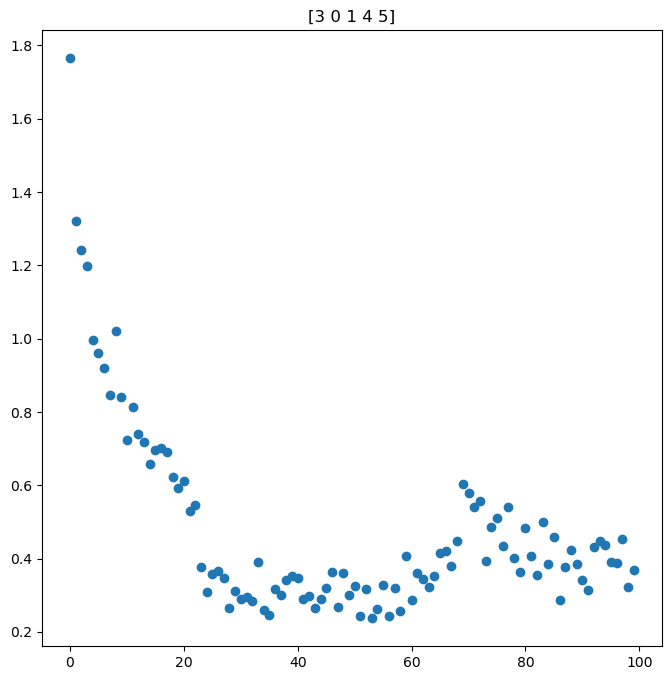

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 11.17825157308132
loss_and_grads loss: 11.17825157308132
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all trai

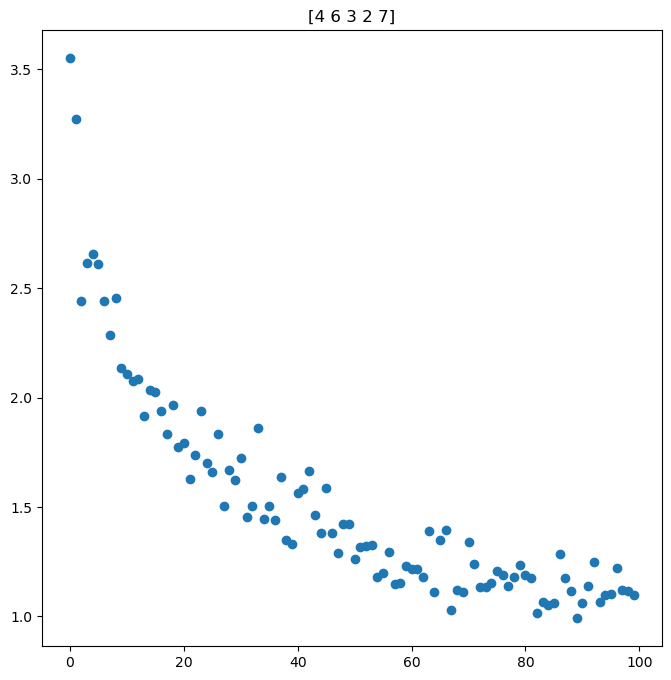

In [36]:





s = 5

for j in range(10):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    chosen_numbers = np.random.choice([0,1,2,3,4,5,6,7], size=s, replace=False)
    for z in chosen_numbers:
        model.A_ct[z][z] = 0
    #model.A_ct[5][5] = 0 still maintains some stability
    #while model.A_ct[2][2] = 0 already makes things crumble
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)
    
    u = x_train[0]           
    t = y_train[0]          
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]     
            tgt = y_train[i]   

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{chosen_numbers}')


   
    plt.show()

- What is interesting about removing 0th, 1st, 2nd, 5th, and 7th diagonal element, is that even though we removed more than half of diagonal elements, the test accuracy is still very good. What we didn't do is remove the 3rd and 4th element

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 7.0505070135132515
loss_and_grads loss: 7.0505070135132515
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

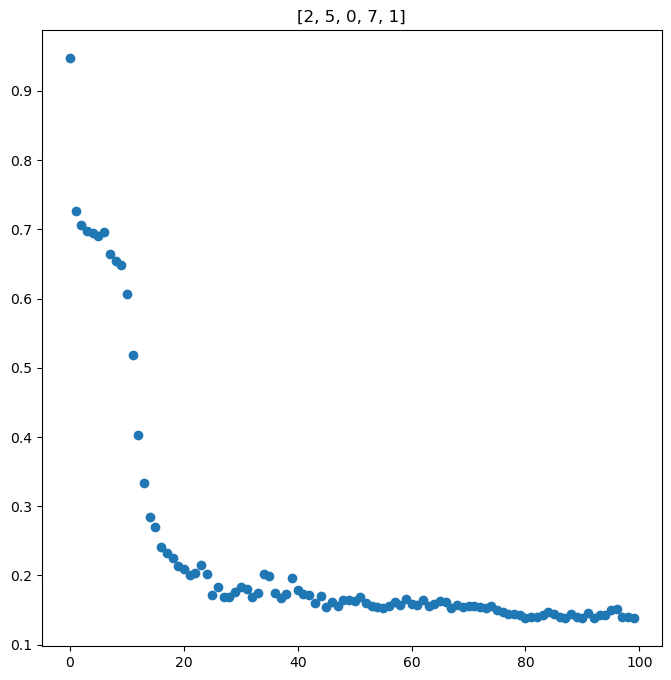

In [37]:
for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    chosen_numbers = [2,5,0,7,1]
    model.A_ct[5][5] = 0
    model.A_ct[2][2] = 0
    model.A_ct[0][0] = 0
    model.A_ct[7][7] = 0
    model.A_ct[1][1] = 0
    
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)
    
    u = x_train[0]           
    t = y_train[0]        
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]     
            tgt = y_train[i]   

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{chosen_numbers}')


   
    plt.show()



- the performance of the prevbit experiment is still good even when the sequence length is huge (T = 10,000)
- despite the fact that A matrix is called more times during backpropagation-in-time process when T = 10,000, the logits (and hence the gradient) doesn't explode with large sequence lengths
- (takes a very long time to run, due to T = 10,000)

In [ ]:
# Generate data

# Size of data matters alot, especially for how simple the task is. If the training data is very large, then the model will learn it within one epoch and the average loss will be small even on the first pass
x_train, y_train, x_test, y_test = make_train_test(
    n_train=100,
    n_test=10,
    T=10000,
    seed=0,
)

model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
num_epochs = 100
learning_rate = 1e-2



u = x_train[0]         
t = y_train[0]            
logits, _ = model.forward(u)
#print(logits)
probs = sigmoid(logits)

eps = 1e-8
loss_manual = -np.mean(
    t * np.log(probs + eps) +
    (1 - t) * np.log(1 - probs + eps)
)
print("manual BCE on first sequence:", loss_manual)

loss, _ = model.loss_and_grads(u, t)
print("loss_and_grads loss:", loss)

print(model.A_ct)
print(model.A)
los = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(x_train.shape[0]):
        u = x_train[i]      
        tgt = y_train[i]    

        loss, grads = model.loss_and_grads(u, tgt)
        

        
        model.step(grads, lr=learning_rate)
        epoch_loss += loss
    los.append(epoch_loss / x_train.shape[0])
    print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

print(model.A)


print(model.forward(x_train[0])[0])

# Testing ERror
print("mean of y_train:", y_train.mean())
print("min target:", y_train.min(), "max target:", y_train.max())
print("mean target over all train data:", y_train.mean())

u = x_train[0].reshape(-1)
t = y_train[0].reshape(-1)
print("input:  ", u.astype(int).tolist())
print("target: ", t.astype(int).tolist())

import numpy as np
eps = 1e-8
p = 0.01
y = y_train.reshape(-1)   # flatten all targets

baseline_loss = -np.mean(
    y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
)

print("baseline constant-p loss:", baseline_loss)



N = x_test.shape[0]
total_loss = 0.0
total_correct = 0
total_bits = 0

for i in range(N):
    u = x_test[i]      # (T, 1)
    tgt = y_test[i]    # (T, 1)
    

    # forward pass only (no grads)
    logits, _ = model.forward(u)

    # loss for this sequence
    loss = binary_cross_entropy(logits, tgt)
    total_loss += loss

    # compute accuracy for this sequence
    probs = sigmoid(logits)
    preds = (probs > 0.5).astype(int)   # threshold at 0.5

    print('\n\n')

    total_correct += (preds == tgt).sum()
    total_bits += tgt.size

avg_loss = total_loss / N
accuracy = total_correct / total_bits

print(avg_loss)
print(accuracy)


manual BCE on first sequence: 0.6887853548716563
loss_and_grads loss: 0.6887853548716563
[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
[[ 3.33333333e-01 -3.37864825e-16 -2.06854932e-16  1.93156033e-16
   1.8779134

In [ ]:
#prev_bit vs memory
#as you increase sequence length
#the logits increase in magniute with memroy, logits stay witin their magnitues with prev_bit
#the hidden state components increase slowly with prev_bit and dont' increase much in magntiude, the hiddden state componente increase a lot quicker since they increase in magnitude in memory



#also shows that since A doesn't need to remmeber much in the past, stuff doesn't explode there
    

#memory = shows that since A needs to remember lots in in the past, stuff does explode there compared to prev_bit

#the differecnes in how quickly the hidden state and the logits increase in magniutde between memerouy and prev_bit
#shows that if A doesn't need to remember much in the past, rescuriveve trainign does well, but if
#if it needs to remember stuff in teh past, logits and hidden states start to increase in magnitude which contributes
#towards the loss function eventually starting to increase, evne with very low learning rate

#what seperates ssm from rnn in this regards (when needing to remember information from many sequences ago,
#is that ssms are linear and could be trained convolutionally --> we did not experiment with this
